In [1]:
# The gp_sfh.py file contains a simple GP framework that we'll be using
from gp_sfh import *
from gp_sfh_kernels import *

# also add dense basis for realistic SFHs
import dense_basis as db

#--------------------------------------------------------------------------------------
# import FSPS and set up a fiducial set of parameters (dust, metallicity, IMF, etc.)
#--------------------------------------------------------------------------------------

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

from copy import deepcopy
import hickle

import fsps
sp = fsps.StellarPopulation(imf_type=2, zcontinuous=1)
sp.params['imf_type'] = 1 # Chabrier
sp.params['logzsol'] = 0.0 # Solar metallicity
sp.params['dust_type'] = 2 # Calzetti
sp.params['dust2'] = 0.2
sp.params['sfh'] = 3
sp.params['add_neb_emission'] = True
sp.params['add_neb_continuum'] = True

import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style('white')
import pandas as pd
import corner

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.


In [2]:
kernel_params_MW_1dex = [1.0, 2500/1e3, 150/1e3, 0.03, 25/1e3]
kernel_params_dwarf_1dex = [1.0, 30/1e3, 150/1e3, 0.03, 10/1e3]
kernel_params_noon_1dex = [1.0, 200/1e3, 100/1e3, 0.03, 50/1e3]
kernel_params_highz_1dex = [1.0, 15/1e3, 16/1e3, 0.03, 6/1e3]

TCF20_scattervals = [0.17, 0.53, 0.24, 0.27]
kernel_params_MW_TCF20 = [np.sqrt(TCF20_scattervals[0]**2/(1 + (0.03)**2)), 2500/1e3, 150/1e3, 0.03*np.sqrt(TCF20_scattervals[0]**2/(1 + (0.03)**2)), 25/1e3]
kernel_params_dwarf_TCF20 = [np.sqrt(TCF20_scattervals[1]**2/(1 + (0.03)**2)), 30/1e3, 150/1e3, 0.03*np.sqrt(TCF20_scattervals[1]**2/(1 + (0.03)**2)), 10/1e3]
kernel_params_noon_TCF20 = [np.sqrt(TCF20_scattervals[2]**2/(1 + (0.03)**2)), 200/1e3, 100/1e3, 0.03*np.sqrt(TCF20_scattervals[2]**2/(1 + (0.03)**2)), 50/1e3]
kernel_params_highz_TCF20 = [np.sqrt(TCF20_scattervals[3]**2/(1 + (0.03)**2)), 15/1e3, 16/1e3, 0.03*np.sqrt(TCF20_scattervals[3]**2/(1 + (0.03)**2)), 6/1e3]

In [3]:
nsamp = 1000
tarr_res = 1000
zval = 1.0
random_seed = 42

case_params = kernel_params_MW_TCF20

case1 = simple_GP_sfh(sp=sp, cosmo=cosmo, zval = zval)
case1.get_tarr(n_tarr = tarr_res)
#case1.get_basesfh(sfhtype='MS', mstar = 10.0)
case1.get_basesfh(sfhtype='dirichlet')
case1.kernel = extended_regulator_model_kernel_paramlist


case1.samples = case1.sample_kernel(nsamp = nsamp, random_seed = random_seed, 
                                    force_cov=True, kernel_params = case_params)

unknown basesfh type. set yourself with len of tarr.


100%|██████████| 1000/1000 [00:05<00:00, 181.18it/s]


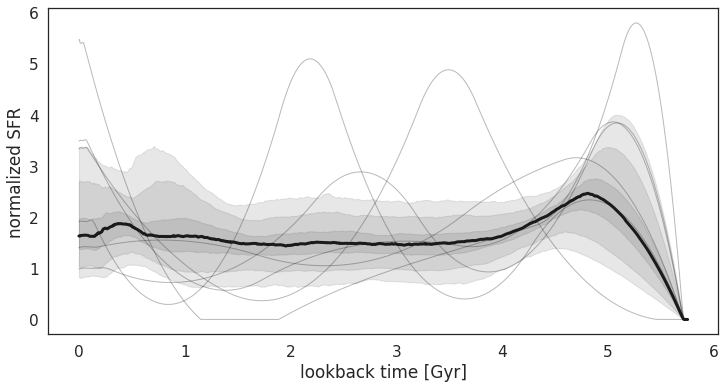

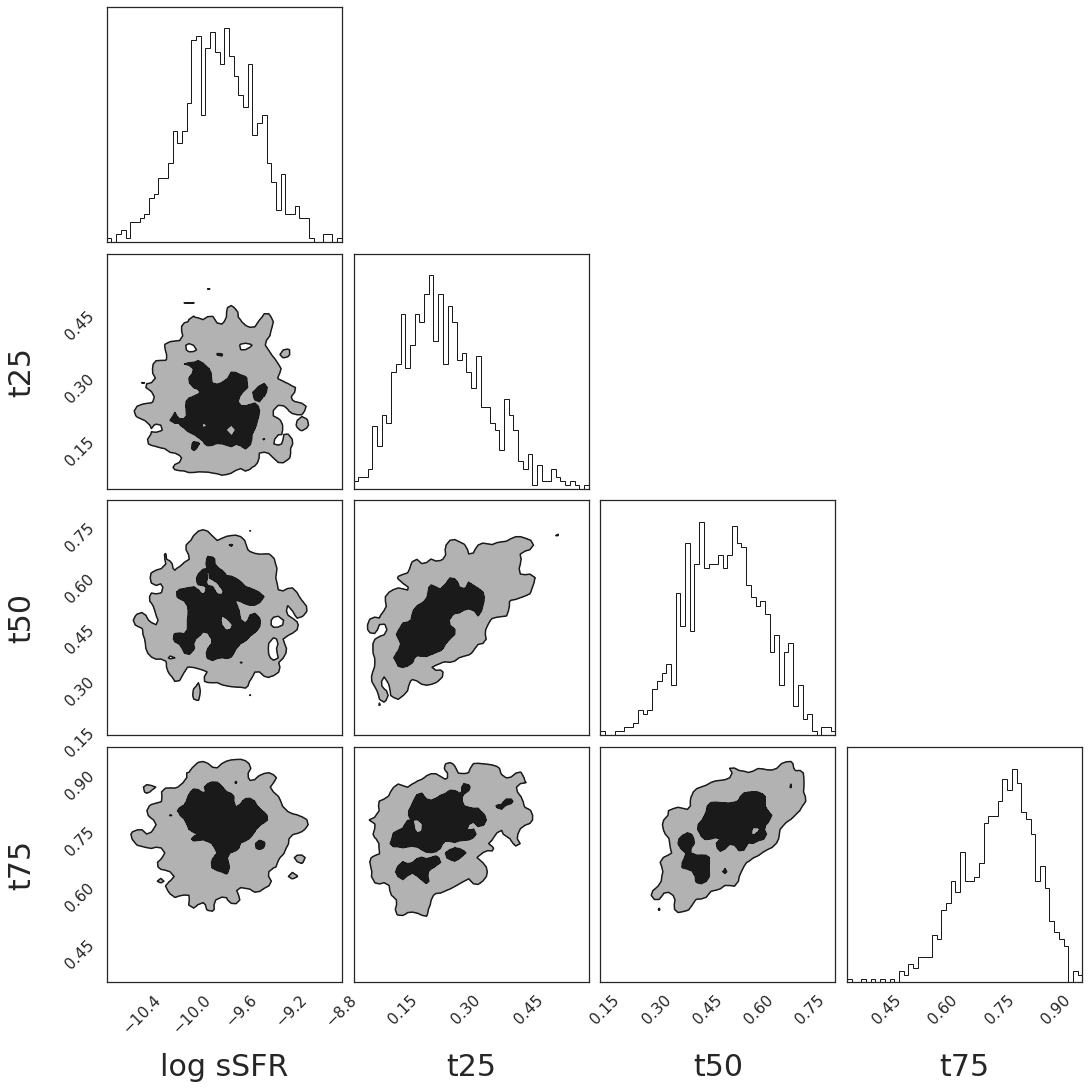

In [4]:
def normal_sfr():
    return np.random.normal(scale=0.3)-0.77

priors = db.Priors()
priors.Nparam = 3
#priors.sfr_prior_type = 'sSFRlognormal'
priors.sample_sfr_prior = normal_sfr
priors.mass_min = 9-1e-6
priors.mass_max = 9+1e-6
priors.sample_sfh_tuple()

#priors.plot_prior_distributions()

priors.plot_sfh_prior(numdraws=1000, zval=zval)

In [5]:
def get_spec(self, nsamp):

    bands = fsps.list_filters()
    filter_wavelengths = [fsps.filters.get_filter(bands[i]).lambda_eff for i in range(len(bands))]

    all_lam, all_spec, all_spec_massnorm, all_mstar, all_emline_wav, all_emline_lum, all_emline_lum_massnorm, all_filtmags, all_basesfhs = [], [], [], [], [], [], [], [], []

    for i in tqdm(range(nsamp)):
        
        temp_sfh, temp_time = db.tuple_to_sfh(priors.sample_sfh_tuple(), zval=zval)
        log_tempsfh = np.log10(temp_sfh)
        log_tempsfh[np.isnan(log_tempsfh)] = -3
        specsfh = 10**(log_tempsfh+self.samples[i, 0:])
        #specsfh = 10**(self.basesfh+self.samples[i, 0:])
        self.sp.set_tabular_sfh(self.tarr, specsfh)
        lam, spec = self.sp.get_spectrum(tage = self.t_univ)
        mstar = self.sp.stellar_mass
        bandmags = self.sp.get_mags(tage = self.cosmo.age(self.zval).value, redshift = self.zval, bands = bands)

        all_lam.append(lam)
        all_spec.append(spec)
        all_spec_massnorm.append(spec/mstar)
        all_mstar.append(mstar)
        all_emline_wav.append(self.sp.emline_wavelengths)
        all_emline_lum.append(self.sp.emline_luminosity)
        all_emline_lum_massnorm.append(self.sp.emline_luminosity / mstar)
        all_filtmags.append(bandmags)
        all_basesfhs.append(log_tempsfh)

    self.lam = all_lam
    self.spec = all_spec
    self.spec_massnorm = all_spec_massnorm
    self.mstar = all_mstar
    self.emline_wav = all_emline_wav
    self.emline_lum = all_emline_lum
    self.emline_lum_massnorm = all_emline_lum_massnorm
    self.basesfhs = all_basesfhs

    # not mass normalized
    self.bands = bands
    self.filter_wavelengths = filter_wavelengths
    self.filtmags = all_filtmags

    return

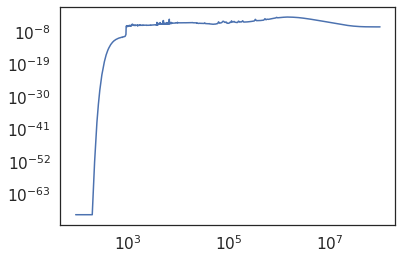

In [9]:
tarr = case1.tarr
basesfh = np.ones_like(tarr)

sp.set_tabular_sfh(tarr, basesfh)
lam, spec = sp.get_spectrum(tage = np.amax(tarr))

plt.loglog(lam, spec)
plt.show()

In [14]:
def calc_spectral_features_single(sp, tage):
    
        lam, spectra = sp.get_spectrum(tage = tage)
        emline_wavs = sp.emline_wavelengths
        emline_lum = sp.emline_luminosity

        ha_lambda = 6562 # in angstrom

        ha_line_index = np.argmin(np.abs(emline_wavs - ha_lambda))
        ha_lum = emline_lum[ha_line_index]

        hdelta_mask = (lam > 4041.60) & (lam < 4079.75)
        #hdelta_cont1_flux = np.trapz(x=lam[hdelta_mask], y = spectra[i][hdelta_mask])
        hdelta_cont1_flux = np.mean(spectra[hdelta_mask])
        hdelta_mask = (lam > 4128.50) & (lam < 4161.00)
        #hdelta_cont2_flux = np.trapz(x=lam[hdelta_mask], y = spectra[i][hdelta_mask])
        hdelta_cont2_flux = np.mean(spectra[hdelta_mask])
        hdelta_cont_flux_av = (hdelta_cont1_flux + hdelta_cont2_flux)/2

        hdelta_mask = (lam > 4083) & (lam < 4122)
        #hdelta_emline_flux = np.trapz(x=lam[hdelta_mask], y = spectra[i][hdelta_mask])
        hdelta_emline_fluxes = spectra[hdelta_mask]
        hdelta_emline_fluxratios = hdelta_emline_fluxes / hdelta_cont_flux_av
        hdelta_ew = np.sum(1 - hdelta_emline_fluxratios)

        dn4000_mask = (lam>3850) & (lam < 3950)
        dn4000_flux1 = np.mean(spectra[dn4000_mask])
        dn4000_mask = (lam>4000) & (lam < 4100)
        dn4000_flux2 = np.mean(spectra[dn4000_mask])
        dn4000 = dn4000_flux1/dn4000_flux2
        
        return ha_lum, hdelta_ew, dn4000

In [15]:
ha_lum, hd_ew, dn4000 = calc_spectral_features_single(sp, tage = np.amax(tarr))

# effect of varying metallicity

In [61]:
Zvals = np.arange(-1.5, 0.6, 0.1)

masses, sfrs, ha_lums, hd_ews, dn4000s = [], [], [], [], []

for Zi, Z in enumerate(Zvals):
    
    print('working at metallicity: %.1f' %Z)
    sp.params['logzsol'] = Z
    sp.set_tabular_sfh(tarr, basesfh)
    lam, spec = sp.get_spectrum(tage = np.amax(tarr))
    masses.append(np.log10(sp.stellar_mass))
    sfrs.append(np.log10(sp.sfr))
    ha_lum, hd_ew, dn4000 = calc_spectral_features_single(sp, tage = np.amax(tarr))
    ha_lums.append(ha_lum)
    hd_ews.append(hd_ew)
    dn4000s.append(dn4000)
    

working at metallicity: -1.5
working at metallicity: -1.4
working at metallicity: -1.3
working at metallicity: -1.2
working at metallicity: -1.1
working at metallicity: -1.0
working at metallicity: -0.9
working at metallicity: -0.8
working at metallicity: -0.7
working at metallicity: -0.6
working at metallicity: -0.5
working at metallicity: -0.4
working at metallicity: -0.3
working at metallicity: -0.2
working at metallicity: -0.1
working at metallicity: 0.0
working at metallicity: 0.1
working at metallicity: 0.2
working at metallicity: 0.3
working at metallicity: 0.4
working at metallicity: 0.5


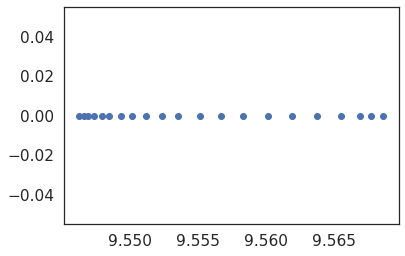

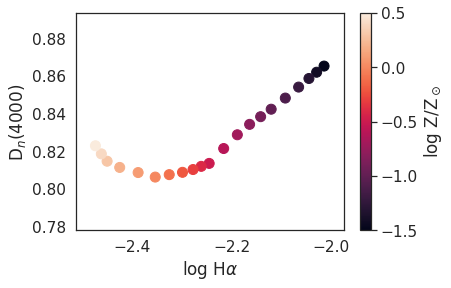

In [62]:
plt.plot(masses, sfrs,'o')
plt.show()

plt.scatter(np.log10(ha_lums)-masses, dn4000s,s=100,c=Zvals)
clbr = plt.colorbar()
clbr.set_label('log Z/Z$_\odot$')
plt.xlabel(r'log H$\alpha$')
plt.ylabel('D$_n$(4000)')
plt.savefig('figures/effect_varying_metallicity_zoom.png',bbox_inches='tight')
plt.show()

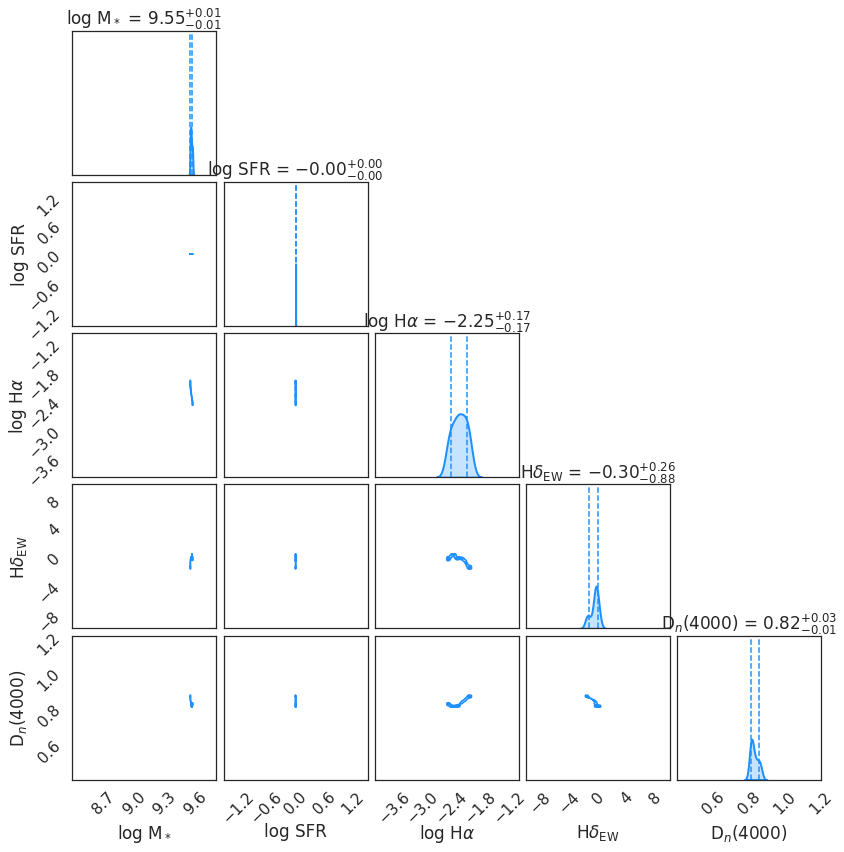

In [63]:
case1_specfeatures = np.vstack((masses, sfrs+np.random.normal(scale=0.001,size=len(sfrs)),
                                np.log10(ha_lums)-masses, hd_ews, dn4000s))

smoothval=1.0
lims = [(8.4,9.8),(-1.5,1.5),(-4,-1),(-10,10),(0.4,1.2)]

fig = corner.corner(case1_specfeatures.T, 
                  labels=['log M$_*$', 'log SFR', r'log H$\alpha$', r'H$\delta_{\rm EW}$', 'D$_n$(4000)'],
                  levels=[1 - np.exp(-(1/1)**2/2),1 - np.exp(-(2/1)**2/2)], quantiles=(0.16,0.84), 
                  plot_datapoints=False, fill_contours=True, smooth=smoothval, show_titles=True,
                  color = 'dodgerblue', hist_kwargs={'lw':0, 'density':True})
axes = np.array(fig.axes).reshape((5,5))
all_specfeatures = case1_specfeatures

for kdei in range(5):
    axkde = axes[kdei, kdei]
    sns.kdeplot(case1_specfeatures[kdei,0:],shade=True,lw=2,color='dodgerblue',ax=axkde)
    axkde.set_ylabel('')

for i in range(5):
    ax = axes[i, i]
    ax.set_xlim(lims[i])
    
    
    for j in range(i):
        ax = axes[i,j]
        ax.set_xlim(lims[j])
        ax.set_ylim(lims[i])

plt.savefig('figures/effect_varying_metallicity.png',bbox_inches='tight')
plt.show()

# effect of dust attenuation

In [64]:
sp.params['logzsol'] = 0.0

dustvals = np.arange(0.0,2.1,0.1)

masses, sfrs, ha_lums, hd_ews, dn4000s = [], [], [], [], []

for Avi, Av in enumerate(dustvals):
    
    print('working at dust: %.1f' %Av)
    
    sp.params['dust2'] = Av
    
    sp.set_tabular_sfh(tarr, basesfh)
    lam, spec = sp.get_spectrum(tage = np.amax(tarr))
    masses.append(np.log10(sp.stellar_mass))
    sfrs.append(np.log10(sp.sfr))
    ha_lum, hd_ew, dn4000 = calc_spectral_features_single(sp, tage = np.amax(tarr))
    ha_lums.append(ha_lum)
    hd_ews.append(hd_ew)
    dn4000s.append(dn4000)
    

working at dust: 0.0
working at dust: 0.1
working at dust: 0.2
working at dust: 0.3
working at dust: 0.4
working at dust: 0.5
working at dust: 0.6
working at dust: 0.7
working at dust: 0.8
working at dust: 0.9
working at dust: 1.0
working at dust: 1.1
working at dust: 1.2
working at dust: 1.3
working at dust: 1.4
working at dust: 1.5
working at dust: 1.6
working at dust: 1.7
working at dust: 1.8
working at dust: 1.9
working at dust: 2.0


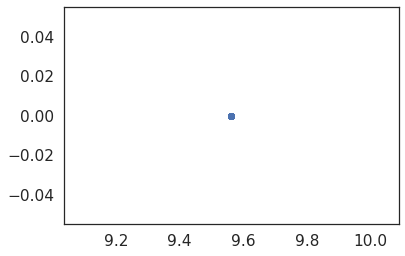

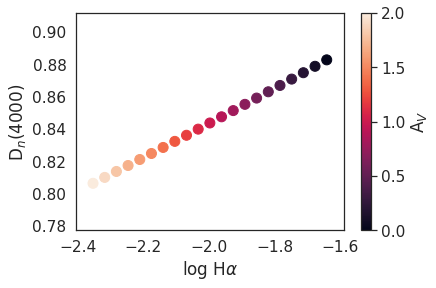

In [68]:
plt.plot(masses, sfrs,'o')
plt.show()

plt.scatter(np.log10(ha_lums)-masses, dn4000s,s=100,c=dustvals)
clbr = plt.colorbar()
clbr.set_label('A$_V$')
plt.xlabel(r'log H$\alpha$')
plt.ylabel('D$_n$(4000)')
plt.savefig('figures/effect_varying_dust.png',bbox_inches='tight')
plt.show()

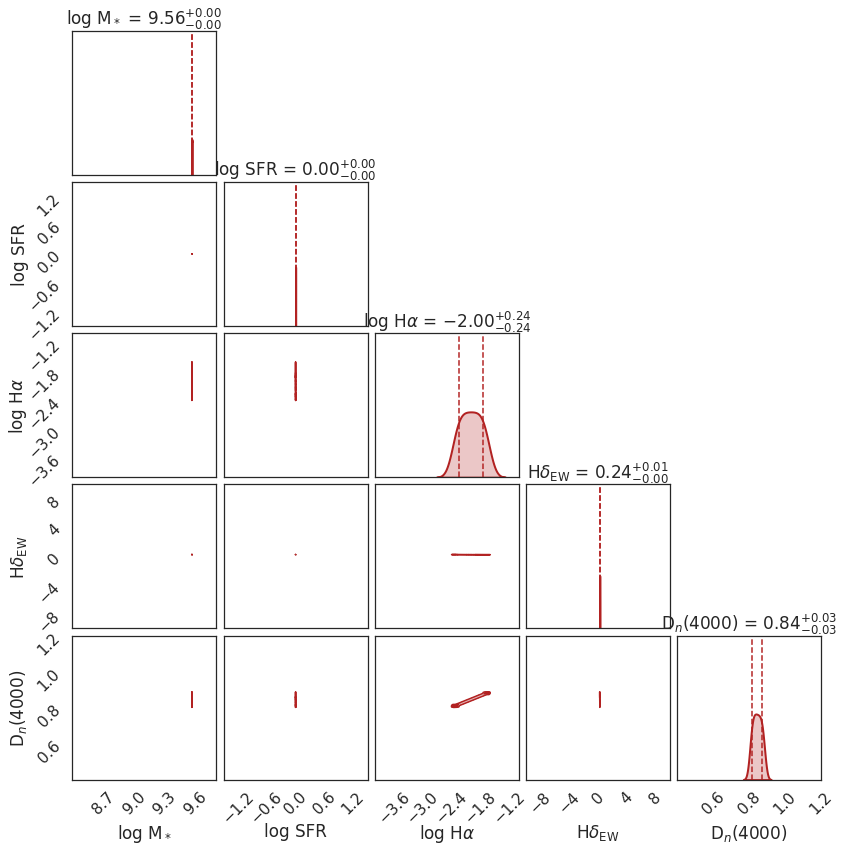

In [67]:
case1_specfeatures = np.vstack((masses+np.random.normal(scale=0.001,size=len(sfrs)), 
                                sfrs+np.random.normal(scale=0.001,size=len(sfrs)),
                                np.log10(ha_lums)-masses, hd_ews, dn4000s))

smoothval=1.0
lims = [(8.4,9.8),(-1.5,1.5),(-4,-1),(-10,10),(0.4,1.2)]

fig = corner.corner(case1_specfeatures.T, 
                  labels=['log M$_*$', 'log SFR', r'log H$\alpha$', r'H$\delta_{\rm EW}$', 'D$_n$(4000)'],
                  levels=[1 - np.exp(-(1/1)**2/2),1 - np.exp(-(2/1)**2/2)], quantiles=(0.16,0.84), 
                  plot_datapoints=False, fill_contours=True, smooth=smoothval, show_titles=True,
                  color = 'firebrick', hist_kwargs={'lw':0, 'density':True})
axes = np.array(fig.axes).reshape((5,5))
all_specfeatures = case1_specfeatures

for kdei in range(5):
    axkde = axes[kdei, kdei]
    sns.kdeplot(case1_specfeatures[kdei,0:],shade=True,lw=2,color='firebrick',ax=axkde)
    axkde.set_ylabel('')

for i in range(5):
    ax = axes[i, i]
    ax.set_xlim(lims[i])
    
    
    for j in range(i):
        ax = axes[i,j]
        ax.set_xlim(lims[j])
        ax.set_ylim(lims[i])
        
plt.savefig('figures/effect_varying_dust_zoom.png',bbox_inches='tight')
plt.show()